In [7]:
from tree_sitter import Language, Parser
import networkx as nx
import matplotlib.pyplot as plt
from regraph import plot_graph, plot_instance, plot_rule, NXGraph, Rule
import sys
from builder_functions.graph_builder import *
from builder_functions.pattern_builder import *
from parser_v2 import *

List of nodes: 
	 1 {'type': {'call'}, 'text': {b'library(tidyverse)'}, 'parent_id': {0}, 'identifier': {b'tidyverse', b'library'}, 'label': {'package_import'}}
	 3 {'type': {'call'}, 'text': {b'list.files(path = "../input")'}, 'parent_id': {0}, 'identifier': {b'path', b'list.files'}, 'label': {'user_output'}}
	 6 {'type': {'equals_assignment'}, 'text': {b'salary_data=read_csv("../input/salary-data-simple-linear-regression/Salary_Data.csv")'}, 'parent_id': {0}, 'identifier': {b'read_csv', b'salary_data'}, 'label': {b'salary_data=read_csv("../input/salary-data-simple-linear-regression/Salary_Data.csv")'}}
	 9 {'type': {'call'}, 'text': {b'summary.data.frame(salary_data)'}, 'parent_id': {0}, 'identifier': {b'salary_data', b'summary.data.frame'}, 'label': {b'summary.data.frame(salary_data)'}}
	 11 {'type': {'call'}, 'text': {b'plot(salary_data$YearsExperience,salary_data$Salary,xlab="Salary",ylab="Years of experience",main="Salary with respect to years of experience",col="blue")'}, 'paren

In [9]:
from test_scripts import Python, R

In [10]:
code = Python.code_2

In [14]:
code

'\n        import numpy as np\n        def perform_bernoulli_trials(n, p):\n        # Initialize number of successes: n_success\n        n_success = 0\n        return n_success\n        '

In [11]:
language = "python"
parsed_ast = parse(language, code)

In [15]:
parsed_ast.root_node.text

b'import numpy as np\n        def perform_bernoulli_trials(n, p):\n        # Initialize number of successes: n_success\n        n_success = 0\n        return n_success\n        '

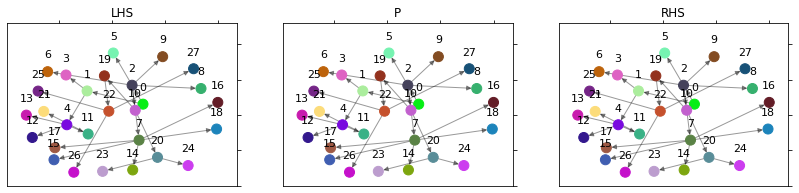

In [5]:
language = "python"
parsed_ast = parser_test.parse(language, code)
G = graph_builder.bfs_tree_traverser(parsed_ast)
rule = Rule.from_transform(G)
plot_rule(rule)

--------------------------------------

<h2>Graph Simplification by Node Generalization</h2>

In [11]:
parsed_json = G.to_json()

# print clear view of all nodes and their edges
print("List of nodes: ")
for n, attrs in G.nodes(data=True):
    print("\t", n, attrs)
print("List of edges: ")
for s, t, attrs in G.edges(data=True):
    print("\t{}->{}".format(s, t), attrs)

List of nodes: 
	 0 {'type': {'module'}, 'text': {b'import numpy as np\nimport libs as l\n\ndef perform_bernoulli_trials(n, p):\n\n    # Initialize number of successes: n_success\n    n_success = 0\n    return n_success\n    \nprint("Python is great!")\n\nnp.ndarray(size=(5,5))\n\nx = 5 * 3\n'}}
	 1 {'type': {'import_statement'}, 'text': {b'import numpy as np'}, 'parent_id': {0}}
	 2 {'type': {'import_statement'}, 'text': {b'import libs as l'}, 'parent_id': {0}}
	 3 {'type': {'function_definition'}, 'text': {b'def perform_bernoulli_trials(n, p):\n\n    # Initialize number of successes: n_success\n    n_success = 0\n    return n_success'}, 'parent_id': {0}}
	 4 {'type': {'expression_statement'}, 'text': {b'print("Python is great!")'}, 'parent_id': {0}}
	 5 {'type': {'expression_statement'}, 'text': {b'np.ndarray(size=(5,5))'}, 'parent_id': {0}}
	 6 {'type': {'expression_statement'}, 'text': {b'x = 5 * 3'}, 'parent_id': {0}}
	 7 {'type': {'import'}, 'text': {b'import'}, 'parent_id': {1}}

In [56]:
def remove_descendants(node_type, instances, rule):
    print(node_type)
    for ins in instances:
        node_id = ins[node_type]
        print(str(node_id) + ":")
        desc = G.descendants(node_id)
        print(desc)
        for id in list(desc):
            rule.inject_remove_node(id)
    return rule


# removes all the nodes and edges of all nodes in rule whose ids are not in the list
def remove_everything_else(ids, rule, num_nodes):
    for i in range(num_nodes):
        if i not in ids:
            rule.inject_remove_node(i)
    return rule


# gets the ids of all of the nodes of a certain "type" in an instance of a graph
def get_ids(node_type, instances):
    ids = []
    for ins in instances:
        node_id = ins[node_type]
        ids.append(node_id)
    return ids

# creates a pattern to filter a graph based on "node type"
# attr_name -> name given to the variable used to identify this node type
# node_type -> the type of node that wants to be filtered
def create_simple_pattern(attr_name, node_type):
    pattern = NXGraph()
    pattern.add_node(attr_name)
    pattern.add_node_attrs(attr_name, {"type" : node_type})
    return pattern

# creates a subgraph of the nodes given in ids, searches for their descendants that match the different given patterns
# and adds the text attribute of nodes that match those patterns as an attribute to the ascendant node
def add_attrs_from_patterns(ids, patterns, is_import):

    for id in ids:
        subg_nodes = list(G.descendants(id)) if is_import else list(G.successors(id))
        subg_nodes.append(id)
        subgraph = G.generate_subgraph(G, subg_nodes)
        
        for patt in patterns:
            
            instances = subgraph.find_matching(patt[1])
            sub_id = get_ids(patt[0], instances)
            
            G.add_node_attrs(id, attrs={patt[0] : subgraph.get_node(sub_id[0])["text"]})
            

# adds an edge between the parent of a node and all the children of that same node (grandparent - grandchildren connection)
# this is necessary in order to later be able to remove those nodes that only serve as connectors
def connect_parent_and_children(ids, rule):
    for id in ids:
        parent_id = list(G.predecessors(id))[0]
        for child_id in list(G.successors(id)):
            rule.inject_add_edge(parent_id, child_id)
    return rule

----------

<h3>Approach: Specify "relevant" nodes and delete the rest</h3>

<b>Create patterns to select the "relevant" nodes:</b>

In [28]:
pattern1 = create_simple_pattern("import", "import_statement")
pattern2 = create_simple_pattern("function_def", "function_definition")
pattern3 = create_simple_pattern("function_call", "call")
pattern4 = create_simple_pattern("var_assignment", "assignment")
pattern5 = create_simple_pattern("first_node", "module")
pattern6 = create_simple_pattern("code_block", "block")
pattern7 = create_simple_pattern("if", "if_statement")
pattern8 = create_simple_pattern("for", "for_statement")
pattern9 = create_simple_pattern("expr_statement", "expression_statement")

In [40]:
G = parse_py(code_3)
rule = Rule.from_transform(G)
all_ids = []

<b>Import statements:</b><br>

In [41]:
# pattern matching of import_statements
instances = G.find_matching(pattern1)
this_ids = get_ids("import", instances)
all_ids += this_ids

patterns = []

# pattern to get the library name
patt = create_simple_pattern("library", "dotted_name")
patterns.append(("library", patt))

# pattern to get the alias
patt = create_simple_pattern("alias", "identifier")
patterns.append(("alias", patt))

add_attrs_from_patterns(this_ids, patterns, True)

<p style="color:red;"><b>Missing cases when import statements are called using "from lib import x".</b></p>

<b>Functions definitions:</b>

In [42]:
# pattern matching of function_definition
instances = G.find_matching(pattern2)
this_ids = get_ids("function_def", instances)
all_ids += this_ids

patterns = []

# pattern to get the function name
patt = create_simple_pattern("function", "identifier")
patterns.append(("function", patt))

# pattern to get the parameters
patt = create_simple_pattern("parameters", "parameters")
patterns.append(("parameters", patt))

add_attrs_from_patterns(this_ids, patterns, False)

<p style="color:red;"><b>Add return statements?</b></p>

<b>Functions calls:</b>

In [43]:
# pattern matching of function call
instances = G.find_matching(pattern3)
this_ids = get_ids("function_call", instances)
all_ids += this_ids

patterns = []

# pattern to get the function arguments
patt = create_simple_pattern("arguments", "argument_list")
patterns.append(("arguments", patt))

add_attrs_from_patterns(this_ids, patterns, False)

<b>Code blocks (connector node):</b>

In [44]:
instances = G.find_matching(pattern6)
this_ids = get_ids("code_block", instances)
#all_ids += this_ids

rule = connect_parent_and_children(this_ids, rule)

# for id in this_ids:
#     print(id)
#     rule.inject_remove_node(id)

<b>Expression statements (connector node):</b>

In [45]:
instances = G.find_matching(pattern9)
this_ids = get_ids("expr_statement", instances)
#all_ids += this_ids

rule = connect_parent_and_children(this_ids, rule)

# for id in this_ids:
#     print(id)
#     rule.inject_remove_node(id)

<p style="color:red;"><b>Solve issue where expression statements end up being disconnected from the rest of the graph if their parent is an already removed "block" node</b></p>

<b>To do:</b>
<ul>
    <li>for loops</li>
    <li>while loops</li>
    <li>variable assignments</li>
    <li>if statements</li>
    <li>else if and else statements</li>
</ul>

In [46]:
instances = G.find_matching(pattern4)
this_ids = get_ids("var_assignment", instances)
all_ids += this_ids

instances = G.find_matching(pattern5)
this_ids = get_ids("first_node", instances)
all_ids += this_ids

instances = G.find_matching(pattern7)
this_ids = get_ids("if", instances)
all_ids += this_ids

instances = G.find_matching(pattern8)
this_ids = get_ids("for", instances)
all_ids += this_ids


<p style="color:red;"><b>We need to find more types of nodes and create patterns for each of them.</b></p>

<p style="color:red;"><b>We need to test if what we have also works with R.</b></p>

<b>Delete all nodes that are not "relevant":</b>

In [47]:
rule = remove_everything_else(all_ids, rule, len(parsed_json["nodes"]))

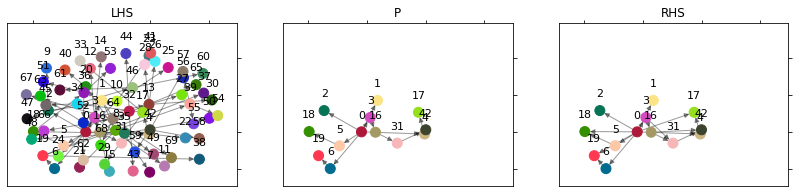

In [48]:
plot_rule(rule)

--------

<h3>Approach: Specify "relevant" nodes and remove all their descendants</h3>

In [124]:
rule = Rule.from_transform(G)

instances1 = G.find_matching(pattern1)
rule = remove_descendants("import", instances1, rule)

instances2 = G.find_matching(pattern2)
rule = remove_descendants("function", instances2, rule)

instances3 = G.find_matching(pattern3)
rule = remove_descendants("expression", instances3, rule)

plot_rule(rule)

import
1:
{3, 4, 11, 12, 13, 21}
function
2:
{5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27}
expression
19:
{25, 26, 27, 22}


RuleError: Node '25' does not exist in the preserved part

<b>Won't work since we won't be able to analyze the content of a function for example, since everything inside would be deleted. Nested functions wouldn't be possible.</b>

----------------------------------

<h2>Playground</h2>

In [1]:
from tree_sitter import Language, Parser
import networkx as nx
import matplotlib.pyplot as plt
from regraph import plot_graph, plot_instance, plot_rule, NXGraph, Rule
import sys
from builder_functions.graph_builder import *
from builder_functions.pattern_builder import *
from parser_v2 import *
import pandas as pd
import test_scripts

In [52]:
language = 'python'
code = test_scripts.Python.code_2
tree_sitter = parse(language, code)

# traverse tree-sitter -> get NXGraph
G = bfs_tree_traverser(tree_sitter)

# rewrite graph
rename_graph_types(G, language)

# TODO: Replace all import aliases with full path of the function or object being called
# replace_imports()
# G = clear_graph(nxgraph)
# G = arrange_graph_v3(G)
# G = rewrite_graph(G, language)

[19,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 41,
 43,
 45,
 177,
 181,
 54,
 56,
 57,
 59,
 81,
 84,
 87,
 90,
 92,
 94,
 96,
 105,
 114,
 116]

<h3>Work on alias and imported functions issue</h3>
<p>Working on replacing the aliases called in the code base with the complete import path used to define the alias, and also replacing called functions that are in imported, with the entire import path required to use them</p>
<p>This allows the knowledge base to identify the exact function that is being called, and there would be no confusion between two functions that have the same name, but come from different python packages</p>

In [65]:
# TODO: Separate this in functions and add to graph_builder.py

In [54]:
all_import_ids = []

In [55]:
# Patterns to add import_path and alias as parameters to the import_statement nodes
pattern1 = create_simple_pattern("import_statement", "import_statement")

instances1 = G.find_matching(pattern1)
this_ids = get_ids("import_statement", instances1)
all_import_ids += this_ids

patterns = []

patt1 = create_simple_pattern("import_path", "import_path")
patterns.append(patt1)

patt2 = create_simple_pattern("alias", "alias")
patterns.append(patt2)

patt3 = create_simple_pattern("import_path", "imported")
patterns.append(patt3)

add_attrs_from_patterns(this_ids, patterns, False, G)

In [56]:
# Patterns to add import_path as parameter to the import_from_statement nodes
pattern2 = create_simple_pattern("import_from_statement", "import_from_statement")

instances2 = G.find_matching(pattern2)
this_ids = get_ids("import_from_statement", instances2)
all_import_ids += this_ids

patterns = []

patt1 = create_simple_pattern("import_path", "import_path")
patterns.append(patt1)

patt2 = create_simple_pattern("imported", "imported")
patterns.append(patt2)

add_attrs_from_patterns(this_ids, patterns, False, G)

In [57]:
# Find all nodes of type caller_function and function
all_func_ids = []

for node_id in G.nodes():
    node = G.get_node(node_id)
    node_type = list(node["type"])[0]
    
    if node_type == "caller_function" or node_type == "function":
        all_func_ids.append(node_id)

In [58]:
for node_id in all_import_ids:
    node = G.get_node(node_id)
    import_path = list(node["import_path"])[0].decode("utf-8")
    
    for node2_id in all_func_ids:
        node2 = G.get_node(node2_id)
        node2_text = list(node2["text"])[0]
        node2_text = node2_text.decode("utf-8") if type(node2_text) == bytes else node2_text

        if "alias" in node.keys():
            node_alias = list(node["alias"])[0].decode("utf-8")
                        
            if node2_text.split('.')[0] == node_alias:
                split_text = node2_text.split('.')
                split_text[0] = import_path
                node2["text"] = ".".join(split_text)
                print(node2_id)
            
        elif "imported" in node.keys():
            node_imported = list(node["imported"])[0].decode("utf-8")
            
            if node2_text == node_imported:
                imported = list(node["imported"])[0].decode("utf-8")
                node2["text"] = import_path + "." + imported
                print(node2_id)

94
96
181
105
114
116


In [8]:
print_graph(G)

List of nodes: 
	 0 {'type': {'module'}, 'text': {b"import matplotlib\n            import numpy as np\n            import Casita.Papel as pape\n            from sklearn.svm import SVC\n            from sklearn.preprocessing import StandardScaler, Abuelito\n            from sklearn.datasets import make_classification\n            from sklearn.model_selection import train_test_split\n            from sklearn.pipeline import Pipeline\n            X, y = make_classification(random_state=0)\n            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)\n            pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])\n            # The pipeline can be used as any other estimator\n            # and avoids leaking the test set into the train set\n            pipe.fit(X_train, y_train)\n            pipe.score(X_test, y_test)\n            np.array()\n            np()\n            "}}
	 1 {'type': {'import_statement'}, 'text': {b'import matplotlib'}, 'parent_id